In [12]:
import torchvision.models as models                   

import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import math
import torchvision.transforms as transforms
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [13]:
from numpy import asarray, percentile, tile
import torch.nn as nn
from scipy.ndimage import gaussian_filter
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
denormalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225], std = [1/0.229, 1/0.224, 1/0.225] )
def image_converter(im):
    im_copy = im.cpu()
    
    im_copy = denormalize(im_copy.clone().detach()).numpy()
    im_copy = im_copy.transpose(1,2,0)
    im_copy = im_copy.clip(0, 1) 
    return im_copy

def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [4]:
def act_max(model, 
    inp_img, 
    layer_activation, 
    layer_name, 
    unit, 
    brightness,
    contrast,
    saturation,
    hue,
    steps=5, 
    alpha=torch.tensor(0.005),
    theta_decay=0.1,
    theta_every=4,
    theta_width=0.1,
    TV = False,
    Jitter = False
    ):

    best_activation = -float('inf')
    min_loss = float('inf')
    best_img = inp_img
    for k in range(steps):
        old_norm = torch.norm(inp_img)
        #Jitter
        if Jitter and k % 40 == 0:
            transform = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue) #haven't tested enough values for hyperparameters
            inp_img = transform(inp_img)

        inp_img.requires_grad_(True)
        inp_img.retain_grad() 
        inp_img = inp_img.cuda()
        
        # Propagate image
        model(inp_img)
        layer_out = layer_activation[layer_name]

        # Compute gradients
        layer_out[0][unit].backward(retain_graph=True)
        img_grad = inp_img.grad
            
        # Gradient Step
        inp_img = torch.add(inp_img, torch.mul(img_grad, alpha))

        new_norm = torch.norm(inp_img)
        inp_img = torch.mul(inp_img, old_norm/new_norm)

        # #L2_Decay
        # input = torch.mul(input, (1.0 - theta_decay))

        # #Gaussian Blur
        # if k % theta_every == 0:
        #   temp = input.squeeze(0)
        #   temp = temp.detach().numpy()
        #   for channel in range(3):
        #       cimg = gaussian_filter(temp[channel], theta_width)
        #       temp[channel] = cimg
        #   temp = torch.from_numpy(temp)
        #   input = temp.unsqueeze(0)

        # print('step: ', k, 'activation: ', layer_out[0][unit])
        # if k % 10 == 0:
        # if k == steps - 1:
        #     final_image = image_converter(inp_img.squeeze(0))
        #     plt.imshow(final_image)
        #     plt.show()
        #     print('step: ', k, 'activation: ', layer_out[0][unit])
        loss = -1*layer_out[0][unit]
        act = layer_out[0][unit]
        if TV:
            bs_img, c_img, h_img, w_img = inp_img.size()
            w = torch.sum(torch.pow(inp_img[:,:,:,:-1] - inp_img[:,:,:,1:], 2))
            h = torch.sum(torch.pow(inp_img[:,:,:-1,:] - inp_img[:,:,1:,:], 2))
            loss = loss + (1/(torch.norm(img_grad) * h_img * w_img) * (h + w))
        # Keep highest activation
        if loss < min_loss:
            best_activation = act
            min_loss = loss
            best_img = inp_img
    return (best_activation, best_img)

In [14]:
def load_image(img_path, device=False):
    img = Image.open(img_path)
    img = img.resize((256, 256))
    img = img.convert('RGB')
    img = asarray(img).transpose(-1, 0, 1)
    img = img/255
    img = torch.from_numpy(img) 
    img = normalize(img)
    img = img.unsqueeze(0)
    img.requires_grad = True
    if device:
        img = img.type(torch.cuda.FloatTensor)
    else:
        img = img.type(torch.FloatTensor)
    return img


In [6]:
resnet50 = models.resnet50(pretrained = True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

alexnet = models.alexnet(weights='IMAGENET1K_V1')
alexnet.eval().to(device)

Using cache found in C:\Users\phili/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [7]:
# uris = [
#     'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
# ]
# uri = 'https://salient-imagenet.cs.umd.edu/feature_visualization/class_130/feature_484/images/0.jpg'
# input = utils.prepare_input_from_uri(uri).to(device)
# input = load_image('flamingo_image.jpg')
# plt.imshow(image_converter(input.squeeze(0)))
# plt.show()
# transform = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5) #haven't tested enough values for hyperparameters
# inp_img = transform(input)
# inp_img = image_converter(inp_img.squeeze(0))
# plt.imshow(inp_img)
# plt.show()
input1 = torch.rand(3, 256, 256, requires_grad=True)
input1 = input1.type(torch.FloatTensor)
input1 = input1.unsqueeze(0)

In [8]:
activation_dictionary = [{},{}]
# backward_activation_dictionary = {}
# print(layers_name_type(model)[-1])
layer_name = 'classifier_final'
#first_layer_name = 'conv1'
(list(resnet50.children())[-1].register_forward_hook(layer_hook(activation_dictionary[0], layer_name)),
    list(alexnet.children())[-1].register_forward_hook(layer_hook(activation_dictionary[1], layer_name)))

(<torch.utils.hooks.RemovableHandle at 0x1c9cd57f050>,
 <torch.utils.hooks.RemovableHandle at 0x1c9cd57f210>)

In [15]:
steps = 100
#unit = list(value[0]).index(k)   
unit = 130               
alpha = torch.tensor(1.5) 
#input = torch.add(input, torch.norm(input, float('inf')), alpha = (-1)*0.1)   
input1 = input1.cuda()
# input2 = input2.cuda()
# input3 = input3.cuda()

restnet with reg



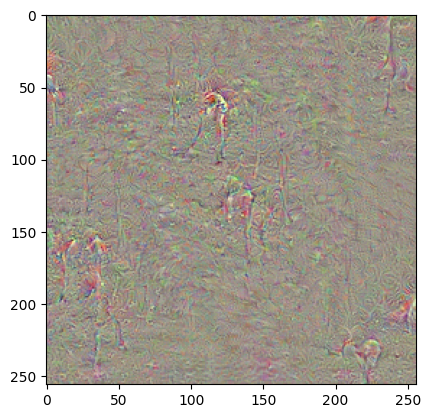

step:  99 activation:  tensor(168.4666, device='cuda:0', grad_fn=<SelectBackward0>)
alex with reg



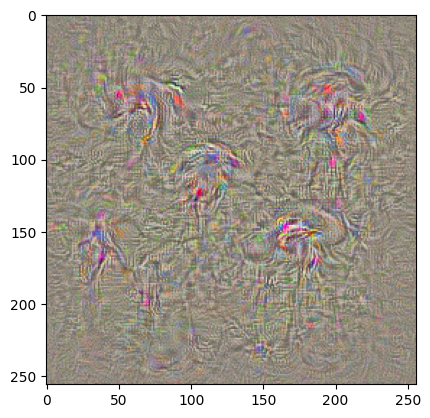

step:  99 activation:  tensor(389.3301, device='cuda:0', grad_fn=<SelectBackward0>)


In [16]:
# brightness = (1,1.2),
# contrast = (1,1.2),
# saturation = (1,1.2),
# hue = 0.5,
print("restnet with reg\n")
acivation1, output1 = act_max(model=resnet50,
                inp_img=input1,
                layer_activation = activation_dictionary[0],
                layer_name = layer_name,
                unit=unit,
                brightness = 0.5,
                contrast = 0.5,
                saturation = 0.5,
                hue = 0.5,
                steps=steps,
                alpha=alpha,
                TV = True,
                Jitter= True
                )
# print("restnet without reg\n")
# acivation2, output2 = act_max(model=resnet50,
#                 inp_img=input1,
#                 layer_activation = activation_dictionary[0],
#                 layer_name = layer_name,
#                 unit=unit,
#                 brightness = (1,1.2),
#                 contrast = (1,1.2),
#                 saturation = (1,1.2),
#                 hue = 0.5,
#                 steps=steps,
#                 alpha=alpha,
#                 )
print("alex with reg\n")
acivation3, output3 = act_max(model=alexnet,
                inp_img=input1,
                layer_activation = activation_dictionary[1],
                layer_name = layer_name,
                unit=unit,
                brightness = 0.5,
                contrast = 0.5,
                saturation = 0.5,
                hue = 0.5,
                steps=steps,
                alpha=alpha,
                TV = True,
                Jitter= True
                )
# print("alexnet without reg\n")
# acivation4, output4 = act_max(model=alexnet,
#                 inp_img=input1,
#                 layer_activation = activation_dictionary[1],
#                 layer_name = layer_name,
#                 unit = unit,
#                  brightness = (1,1.2),
#                 contrast = (1,1.2),
#                 saturation = (1,1.2),
#                 hue = 0.5,
#                 steps=steps,
#                 alpha=alpha,
#                 )